# Twitter Tweets Multi-Class Classification Sentiment Analysis using BERT

## 1. Install dependencies and Data Importing

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")

df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


,0
text,0
label,0
label_name,0


In [3]:
df.label.value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


## 2. Dataset Analysis
- 6 labels, no null, 16k rows [Result from 1st part]

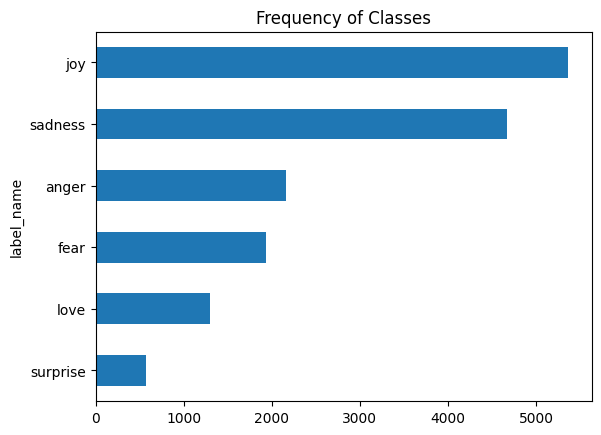

In [4]:
import matplotlib.pyplot as plt

lbl_cnts = df.label_name.value_counts(ascending=True)
lbl_cnts.plot.barh()
plt.title('Frequency of Classes')
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

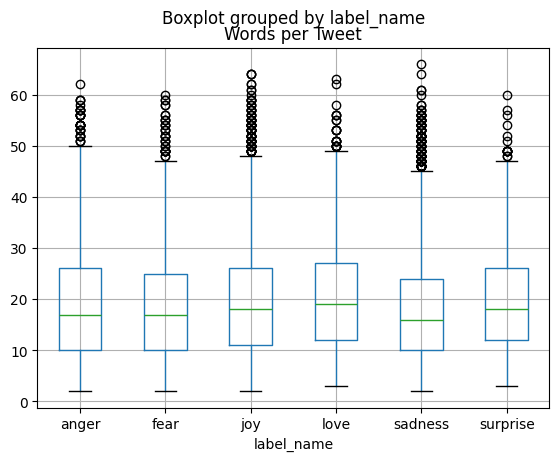

In [5]:
df['Words per Tweet'] = df.text.str.split().apply(len)
df.boxplot('Words per Tweet', by='label_name')

In [6]:
df.describe()

,label,Words per Tweet
count,16000.000000,16000.000000
mean,1.565937,19.166313
std,1.501430,10.986905
min,0.000000,2.000000
25%,0.000000,11.000000
50%,1.000000,17.000000
75%,3.000000,25.000000
max,5.000000,66.000000


## 3. Data Preprocessing
- 6 labels, no null, 16k rows
- avg around 20 words for each label's tweets, MAX:66, MIN:2, AVG:17

### 3.1 Txt to Tokens Conversion

In [7]:
from transformers import AutoTokenizer
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Test tokenizer
txt = 'I love fps game but I hate it at the same time!!'
encoded_txt = tokenizer(txt)
print(encoded_txt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 1045, 2293, 1042, 4523, 2208, 2021, 1045, 5223, 2009, 2012, 1996, 2168, 2051, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [8]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

### 3.2 Data Loader and Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [10]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

### 3.3 Tokenization of the Dataset

In [11]:
dataset['train'][0], dataset['train'][1]

({'text': 'i feel certifiably idiotic right now',
  'label': 0,
  'label_name': 'sadness',
  'Words per Tweet': 6},
 {'text': 'i do for a living and lately more often than not both me and my wife who s also an ubuntu user have been feeling a bit uncertain about linux being the platform where we want to keep working',
  'label': 4,
  'label_name': 'fear',
  'Words per Tweet': 39})

In [12]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2514, 8292, 28228, 22749, 6321, 10041, 2594, 2157, 2085, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2079, 2005, 1037, 2542, 1998, 9906, 2062, 2411, 2084, 2025, 2119, 2033, 1998, 2026, 2564, 2040, 1055, 2036, 2019, 1057, 8569, 3372, 2226, 5310, 2031, 2042, 3110, 1037, 2978, 9662, 2055, 11603, 2108, 1996, 4132, 2073, 2057, 2215, 2000, 2562, 2551, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [13]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [14]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [15]:
# label2id, id2label, mapping to each other
# ('label_name'=label; 'label'=id) in ori dataset
label2id = {x['label_name']: x['label'] for x in dataset['train']}
id2label = {x['label']: x['label_name'] for x in dataset['train']}
label2id, id2label

({'sadness': 0, 'fear': 4, 'joy': 1, 'anger': 3, 'surprise': 5, 'love': 2},
 {0: 'sadness', 4: 'fear', 1: 'joy', 3: 'anger', 5: 'surprise', 2: 'love'})

## 4. Model Building

### 4.1 Original BERT pre-trained from MLM and NLP (without classification head)

In [16]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt) # bert-base-uncased
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [17]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### 4.2 Fine-Tuning Transformers using AutoModelForSequenceClassification (with classification head)

In [18]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_lbls = len(label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Remember to mention the id2label and label2id, the model will save the configurations
# Once we save our model with the configurations, there is no need to convert id2label vice versa during predictions
config = AutoConfig.from_pretrained(model_ckpt, num_labels=num_lbls, id2label=id2label, label2id=label2id)

# Save the configurations, using model_ckpt, and .to(device) means using cuda else cpu
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
device

device(type='cuda')

In [20]:
from transformers import TrainingArguments

BATCH_SIZE = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5, # Often considered a good starting point for Fine-Tuning BERT
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False # Display training's progress bar
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Compute metrics function

In [21]:
!pip install evaluate

# Directly copy from huggingface
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


### 4.3 Build Trainer and Do training

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    tokenizer=tokenizer
)

<ipython-input-22-a5106cd84153>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.509943,0.841875
2,No log,0.317461,0.901250


TrainOutput(global_step=350, training_loss=0.7196625627790179, metrics={'train_runtime': 373.8567, 'train_samples_per_second': 59.916, 'train_steps_per_second': 0.936, 'total_flos': 1001502421516800.0, 'train_loss': 0.7196625627790179, 'epoch': 2.0})

## 5. Model Evaluation

In [24]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.3228200078010559,
 'test_accuracy': 0.8996875,
 'test_runtime': 13.2576,
 'test_samples_per_second': 241.37,
 'test_steps_per_second': 3.771}

In [27]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       933
           1       0.92      0.91      0.92      1072
           2       0.75      0.77      0.76       261
           3       0.89      0.93      0.91       432
           4       0.87      0.88      0.88       387
           5       0.92      0.63      0.75       115

    accuracy                           0.90      3200
   macro avg       0.88      0.85      0.86      3200
weighted avg       0.90      0.90      0.90      3200



In [29]:
label2id

{'sadness': 0, 'fear': 4, 'joy': 1, 'anger': 3, 'surprise': 5, 'love': 2}

Looks like 'surprise' and 'love' are having some issues, can try to increase samples for model to train it.

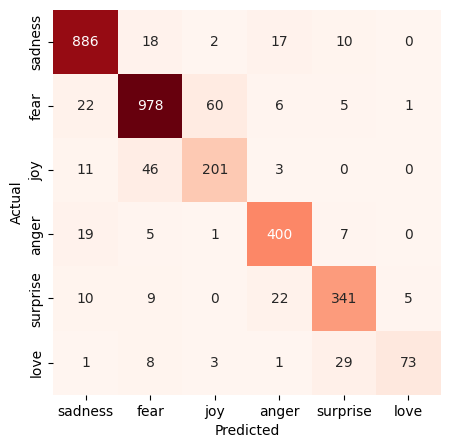

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))

# fmt (format) set to integer, colorbar=False
sns.heatmap(cm, annot=True,
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## 6. Build Prediction Function and Save Model

In [31]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad(): # Make prediction without gradient to make it fast
        outputs = model(**input_encoded)

    logits = outputs.logits # Output float numerical values

    pred = torch.argmax(logits, dim=1).item() # Softmax => Probabilities, choose highest
    return id2label[pred] # Convert the label index into label name

get_prediction(text)

'joy'

In [32]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [34]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model='bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9615402817726135},
 {'label': 'joy', 'score': 0.7519180178642273},
 {'label': 'joy', 'score': 0.6145772933959961},
 {'label': 'sadness', 'score': 0.970589280128479}]

In [35]:
# prompt: download specific folder from google colab into local laptop

from google.colab import files
import shutil
import os

# Create a zip file of the desired folder
folder_to_zip = "/content/bert-base-uncased-sentiment-model"
zip_filename = "model.zip"

shutil.make_archive(zip_filename[:-4], 'zip', folder_to_zip)

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !pip freeze > requirements.txt